# Building a Model to Predict Type of Sample: Loop vs. One-Shot

In [11]:
import pandas as pd
import os
import librosa as lb
import numpy as np

In [12]:
DATA_FOLDER_NAME = 'audio_data'
ONE_SHOT_FOLDER_NAME = 'one-shots_labeled'
LOOP_FOLDER_NAME = 'loops_labeled'
SILENCE_THRESHOLD_DB = 15
NORMALIZING_LEVEL = -0.5

In [13]:
cwd = os.getcwd()
repo_root = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(repo_root, DATA_FOLDER_NAME)
repo_root

'c:\\Users\\emilo\\Desktop\\Mein Zeuchs\\sample-visualizer'

In [14]:
loop_folder = os.path.join(repo_root, DATA_FOLDER_NAME, LOOP_FOLDER_NAME)
one_shot_folder = os.path.join(repo_root, DATA_FOLDER_NAME, ONE_SHOT_FOLDER_NAME)

print(f'Loop folder: {loop_folder}')
print(f'One-shot folder: {one_shot_folder}')

print("Files in loop_folder:", len(os.listdir(loop_folder)))
print("Files in one_shot_folder:", len(os.listdir(one_shot_folder)))


Loop folder: c:\Users\emilo\Desktop\Mein Zeuchs\sample-visualizer\audio_data\loops_labeled
One-shot folder: c:\Users\emilo\Desktop\Mein Zeuchs\sample-visualizer\audio_data\one-shots_labeled
Files in loop_folder: 0
Files in one_shot_folder: 0


## load data

In [15]:
#create dictionary with data and labels from labeld data

#load audio files

def load_audio(file_path):
    audio, sr = lb.load(file_path, sr=None, mono=True)
    return audio, sr

#important: only used for "correct" display of samples -> not supposed to change actual sample
#removes max-amplitude as possible reason to not place similar sample in same cluster

def normalize_amplitude(input_as_array, target_db = NORMALIZING_LEVEL):      #scales amplitude of input_sample to target_db
    max_amplitude = np.max(np.abs(input_as_array))               #max amplitude, positive or negative (important due to polarity being positive or negative)
    target_amplitude = 10 ** (target_db / 20.0)     
    normalized_file = input_as_array * (target_amplitude/ max_amplitude)
    return normalized_file

def trim_start_end_silence(input_as_array):
    trimmed_audio, _ = lb.effects.trim(input_as_array, top_db=SILENCE_THRESHOLD_DB) #cuts sound at start and end of sample, where amplitude is below 30db
    return trimmed_audio

def preprocess_sample(input_as_array):
    normalized = normalize_amplitude(input_as_array)
    preprocessed_array = trim_start_end_silence(normalized)
    return preprocessed_array

#ATTENTION: TAKE NEW FEATURES FOR CLASSIFICATION
def get_features_ovl(audio_as_array, sr):
    '''Extract Features from audio file to classify sounds to Loops or One-Shots
    ----------------------------------------------------------------------------

    Parameters:
        audio_as_array: np.array
            Audio file as numpy array
        sr: int
            Sample rate of audio file
            
    Returns:
        sr: int
            Sample rate of audio file
        sample_lenght: float
            Duration of audio file in seconds
        rms_mean: float
            Mean of Root Mean Square (RMS) of audio file
        rms_std: float
            Standard deviation of Root Mean Square (RMS) of audio file
        spectral_flatness: float
            Spectral flatness of audio file
        spectral_bandwidth: float
            Spectral bandwidth of audio file
        spectral_centroid: float
            Spectral centroid of audio file
        zero_crossing_rate: float
            Zero crossing rate of audio file
        onset_env: float
            Onset envelope of audio file
        spectral_flux: float
            Spectral flux of audio file
        chroma: np.array
            Chroma of audio file
    --------------------------------------------------------------------------

    '''
    dynamic_n_fft = min(2048, len(audio_as_array)) #puts n_fft to 2048 if sample is longer than 2048, else
    sample_lenght = lb.get_duration(y=audio_as_array, sr=sr)
    rms = lb.feature.rms(y=audio_as_array)  #average amplitude of sample
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)
    zero_crossing_rate = lb.feature.zero_crossing_rate(y=audio_as_array) #for noise vs tonal sounds -> higher=more noise
    onset_env = lb.onset.onset_strength(y=audio_as_array, sr=sr) #sum of all forces of transients in sample
    spectral_flux = lb.onset.onset_strength(y=audio_as_array, sr=sr)
    spectral_centroid = lb.feature.spectral_centroid(y=audio_as_array, sr=sr)
    chroma = lb.feature.chroma_stft(y=audio_as_array, sr=sr)
    return  sr, sample_lenght, rms_mean, rms_std, zero_crossing_rate, onset_env, spectral_flux , spectral_centroid, chroma


In [16]:
loop_folder = os.path.join(repo_root, DATA_FOLDER_NAME, LOOP_FOLDER_NAME)
one_shot_folder = os.path.join(repo_root, DATA_FOLDER_NAME, ONE_SHOT_FOLDER_NAME)


def create_df(folder_path, label):
    '''
    Creates a dataframe from the audio files in the folder_path.
    ------------------------------------------------------------
    Parameters:
    folder_path : str
        Path to the folder containing the audio files.
    label : str

    '''
    data_collection = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            try:
                if file.endswith(".wav"):      #use .wav only
                    #print('Detected loop .wav file: ' + file)    
                    audio, sr = load_audio(os.path.join(folder_path, file))
                    if len(audio) == 0:
                        print('Empty audio file: ' + file)
                    preprocessed_sample = preprocess_sample(audio)
                    audio_features = get_features_ovl(preprocessed_sample, sr)  #fit to new extraction function
                    
                    #Fit to new extracted features
                    data_collection.append(
                        {
                        'file_name': file,  
                        'sample_lenght': audio_features[1],
                        'rms_mean': audio_features[2],
                        'rms_std': audio_features[3],
                        'zero_crossing_rate': audio_features[4],
                        'onset_env': audio_features[5],
                        'spectral_flux': audio_features[6],
                        'spectral_centroid': audio_features[7],
                        'chroma': audio_features[8],
                        'label': label                   
                        }
                    )
            except Exception as e:
                print(f"Error processing file {file}: {e}")
                continue
    return pd.DataFrame(data_collection)


df_loops = create_df(loop_folder, 'loop')
df_loops.head()

""


In [17]:
df_one_shots = create_df(one_shot_folder, 'one-shot')
df_one_shots.head()

""


In [18]:
concat_data = pd.concat([df_loops, df_one_shots], ignore_index=True)
print(len(concat_data))
concat_data.columns


0


RangeIndex(start=0, stop=0, step=1)

In [19]:
# Reduziere die Arrays auf Mittelwert und Standardabweichung

concat_data['zero_crossing_rate_mean'] = concat_data['zero_crossing_rate'].apply(np.mean)
concat_data['zero_crossing_rate_std'] = concat_data['zero_crossing_rate'].apply(np.std)



# Optional: Entferne die ursprünglichen Arrays, falls nicht mehr benötigt
concat_data.drop(columns=['spectral_flatness', 'spectral_bandwidth', 'spectral_centroid', 'zero_crossing_rate'], inplace=True)

# Ausgabe zur Kontrolle
concat_data.head()

KeyError: 'zero_crossing_rate'

In [ ]:
# Skalieren der Daten -> Distanz im Raum entscheidend -> Skalierung notwendig
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
metrics = concat_data.drop(['file_name', 'label'], axis=1).columns
name_and_label = concat_data[['file_name', 'label']]

scaler.fit(metrics)  #fitting scaler to data, but not to label or file_name
scaled_features = scaler.transform(metrics) #scaling data
scaled_metrics = pd.DataFrame(scaled_features, columns=metrics) #creating new dataframe with scaled data

scaled_data = pd.concat([name_and_label, scaled_metrics], axis=1) #concatenating scaled data with file_name and label
scaled_data.head()

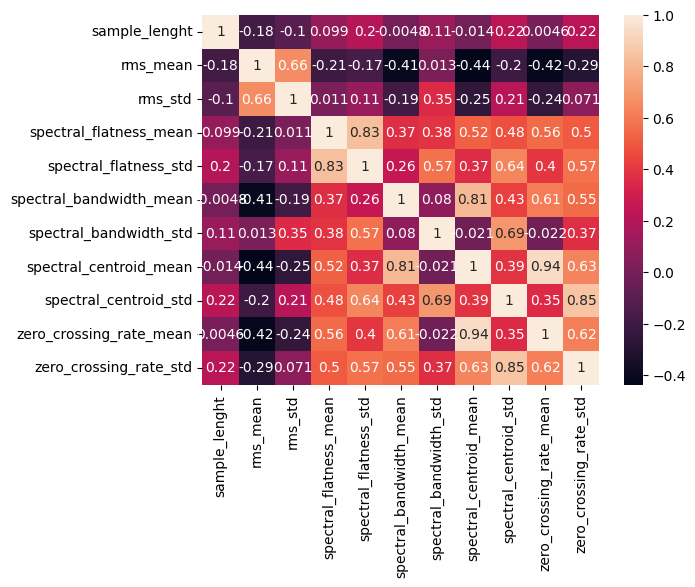

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt

pure_data = scaled_data.drop(columns=['file_name', 'label'])
corrMatrix = pure_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()